In [3]:

import sys
!pip install transformers --user
!pip install sentencepiece --user

     |████████████████████████████████| 2.2MB 12.2MB/s 
     |████████████████████████████████| 3.3MB 55.4MB/s 
     |████████████████████████████████| 870kB 50.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=f2c5c25a902d34cb01c5915c34750489ecaa8c0ff07e544d4d47bbc48a50f482
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
     |████████████████████████████████| 1.2MB 15.5MB/s 


In [1]:
# Import libraries

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import BertTokenizerFast
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
tokenizer =  BertTokenizerFast.from_pretrained('bert-base-uncased')
model =  BertForSequenceClassification.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [5]:
os.getcwd()


'/content'

## Read in txt files and set variables

In [6]:
os.listdir()
os.chdir("/content/drive/MyDrive/w266 Final Project Resources")

In [7]:
all_episodes = []
episodes_true = os.listdir("spongebob_bert_text_updated/class_true")
episodes_false= os.listdir("spongebob_bert_text_updated/cleaned_class_false")
fake_episodes=[]
#episodes_false = os.listdir("spongebob_bert_text_updated/class_false")
for ep in episodes_true:
  
  with open("spongebob_bert_text_updated/class_true/" + ep) as file:
    print(ep)
    all_episodes.append(file.read())
print(len(all_episodes))
for ep in episodes_false:
  with open("spongebob_bert_text_updated/cleaned_class_false/" + ep) as file:

    f = file.read()
    all_episodes.append(f)
    fake_episodes.append(f)
len(all_episodes)

spongebob_0.txt
spongebob_1.txt
spongebob_3.txt
spongebob_4.txt
spongebob_5.txt
spongebob_2.txt
spongebob_6.txt
spongebob_9.txt
spongebob_8.txt
spongebob_7.txt
spongebob_10.txt
spongebob_11.txt
spongebob_15.txt
spongebob_12.txt
spongebob_16.txt
spongebob_14.txt
spongebob_13.txt
spongebob_17.txt
spongebob_19.txt
spongebob_20.txt
spongebob_18.txt
spongebob_24.txt
spongebob_25.txt
spongebob_26.txt
spongebob_23.txt
spongebob_21.txt
spongebob_22.txt
spongebob_28.txt
spongebob_29.txt
spongebob_27.txt
spongebob_32.txt
spongebob_30.txt
spongebob_36.txt
spongebob_33.txt
spongebob_34.txt
spongebob_35.txt
spongebob_31.txt
spongebob_38.txt
spongebob_39.txt
spongebob_37.txt
spongebob_40.txt
spongebob_41.txt
spongebob_44.txt
spongebob_43.txt
spongebob_45.txt
spongebob_42.txt
spongebob_46.txt
spongebob_48.txt
spongebob_47.txt
spongebob_49.txt
spongebob_50.txt
spongebob_51.txt
spongebob_55.txt
spongebob_53.txt
spongebob_54.txt
spongebob_52.txt
spongebob_56.txt
spongebob_57.txt
spongebob_59.txt
spongeb

1093

In [8]:
y_var = np.append(np.array([1]*(len(all_episodes)-len(fake_episodes))),np.array([0]*len(fake_episodes)))


In [9]:
y_var

array([1, 1, 1, ..., 0, 0, 0])

In [10]:
train_texts, val_texts, train_labels,val_labels = train_test_split(all_episodes,y_var, test_size =.1)
  

## Tokenize all text files and store in PyTorch dataset objects

In [11]:
train_encodings= tokenizer(train_texts, truncation=True, padding=True)
val_encodings= tokenizer(val_texts, truncation=True, padding=True)

all_encodings = tokenizer(all_episodes, truncation=True, padding=True)


In [12]:
class SpongebobDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [13]:

train_dataset = SpongebobDataset(train_encodings, train_labels)
val_dataset = SpongebobDataset(val_encodings, val_labels)
all_dataset = SpongebobDataset(all_encodings, y_var)

In [14]:

torch.cuda.empty_cache()

In [16]:
net = model

## Fine-Tune Bert for Filtering

In [17]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
net.to(device)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset ,batch_size = 16)
criterion = nn.BCELoss()
optim = AdamW(net.parameters(), lr=5e-5)
losses = []
losses_val = []
pred = np.array([])
i =0
for ep in range(5):
  print('Epoch: ',ep)
  pred = np.array([])
  label = np.array([])
  with tqdm(total = len(train_loader)) as pbar:
    batch_losses = []
    for batch in train_loader:
      net.train()
      pbar.update(1)
      optim.zero_grad()
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)
      outputs = net(input_ids, attention_mask=attention_mask,labels= labels)
      loss =outputs[0]
      loss.backward()

      print('loss: ',torch.Tensor.cpu(loss).item())
      optim.step()
      pred= np.append(pred,(torch.argmax(torch.softmax(torch.Tensor.cpu(outputs.logits).detach(),dim=-1),dim=1)))
      label = np.append(label,torch.Tensor.cpu(labels).detach())
      batch_losses.append(torch.Tensor.cpu(loss).item())

    net.eval()
    val_losses = []
    val_label = np.array([])
    val_pred = np.array([])
    for v in val_loader:
      val_input_ids = v['input_ids'].to(device)
      val_attention_mask =  v['attention_mask'].to(device)
      val_labels = v['labels'].to(device)
      with torch.no_grad():
        val_output = net(val_input_ids,attention_mask=val_attention_mask,labels= val_labels)

        val_loss =val_output[0]
        val_losses = np.append(val_losses,torch.Tensor.cpu(val_loss).item())
        val_label = np.append(val_label,torch.Tensor.cpu(val_labels).detach())
        val_pred= np.append(val_pred,(torch.argmax(torch.softmax(torch.Tensor.cpu(val_output.logits).detach(),dim=1),dim=1)))
    print('val loss: ', np.mean(val_losses))
      
  
  losses.append(np.mean(batch_losses))
  losses_val.append( np.mean(val_losses))
  print('Training Accuracy:',accuracy_score(label,pred))
  print('Validation Accuracy:',accuracy_score(val_label, val_pred))
net


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch:  0


  3%|▎         | 2/62 [00:00<00:15,  3.95it/s]

loss:  0.7419987320899963


  5%|▍         | 3/62 [00:00<00:19,  3.09it/s]

loss:  0.6308538913726807


  6%|▋         | 4/62 [00:01<00:21,  2.67it/s]

loss:  0.8731719255447388


  8%|▊         | 5/62 [00:01<00:23,  2.45it/s]

loss:  0.7225469946861267


 10%|▉         | 6/62 [00:02<00:24,  2.31it/s]

loss:  0.8227183222770691


 11%|█▏        | 7/62 [00:02<00:24,  2.22it/s]

loss:  0.6609117984771729


 13%|█▎        | 8/62 [00:03<00:24,  2.16it/s]

loss:  0.6245054602622986


 15%|█▍        | 9/62 [00:03<00:24,  2.12it/s]

loss:  0.6775970458984375


 16%|█▌        | 10/62 [00:04<00:24,  2.10it/s]

loss:  0.7951171398162842


 18%|█▊        | 11/62 [00:04<00:24,  2.08it/s]

loss:  0.6739168763160706


 19%|█▉        | 12/62 [00:05<00:24,  2.07it/s]

loss:  0.6794703006744385


 21%|██        | 13/62 [00:05<00:23,  2.06it/s]

loss:  0.6839151978492737


 23%|██▎       | 14/62 [00:06<00:23,  2.06it/s]

loss:  0.733503520488739


 24%|██▍       | 15/62 [00:06<00:22,  2.05it/s]

loss:  0.7217510938644409


 26%|██▌       | 16/62 [00:07<00:22,  2.05it/s]

loss:  0.6725846529006958


 27%|██▋       | 17/62 [00:07<00:22,  2.04it/s]

loss:  0.7587247490882874


 29%|██▉       | 18/62 [00:08<00:21,  2.04it/s]

loss:  0.6799340844154358


 31%|███       | 19/62 [00:08<00:21,  2.04it/s]

loss:  0.6546608209609985


 32%|███▏      | 20/62 [00:09<00:20,  2.04it/s]

loss:  0.6668543815612793


 34%|███▍      | 21/62 [00:09<00:20,  2.03it/s]

loss:  0.6624660491943359


 35%|███▌      | 22/62 [00:10<00:19,  2.03it/s]

loss:  0.6588103175163269


 37%|███▋      | 23/62 [00:10<00:19,  2.03it/s]

loss:  0.616664707660675


 39%|███▊      | 24/62 [00:11<00:18,  2.04it/s]

loss:  0.9197472333908081


 40%|████      | 25/62 [00:11<00:18,  2.04it/s]

loss:  0.6138917207717896


 42%|████▏     | 26/62 [00:12<00:17,  2.04it/s]

loss:  0.8005881905555725


 44%|████▎     | 27/62 [00:12<00:17,  2.04it/s]

loss:  0.6778789758682251


 45%|████▌     | 28/62 [00:13<00:16,  2.04it/s]

loss:  0.6390631198883057


 47%|████▋     | 29/62 [00:13<00:16,  2.04it/s]

loss:  0.720612645149231


 48%|████▊     | 30/62 [00:14<00:15,  2.04it/s]

loss:  0.6947813630104065


 50%|█████     | 31/62 [00:14<00:15,  2.03it/s]

loss:  0.692180335521698


 52%|█████▏    | 32/62 [00:15<00:14,  2.03it/s]

loss:  0.6779474020004272


 53%|█████▎    | 33/62 [00:15<00:14,  2.03it/s]

loss:  0.7261478900909424


 55%|█████▍    | 34/62 [00:16<00:13,  2.03it/s]

loss:  0.6622803807258606


 56%|█████▋    | 35/62 [00:16<00:13,  2.02it/s]

loss:  0.6896271109580994


 58%|█████▊    | 36/62 [00:17<00:12,  2.03it/s]

loss:  0.7120325565338135


 60%|█████▉    | 37/62 [00:17<00:12,  2.03it/s]

loss:  0.6492521166801453


 61%|██████▏   | 38/62 [00:18<00:11,  2.03it/s]

loss:  0.6435267925262451


 63%|██████▎   | 39/62 [00:18<00:11,  2.03it/s]

loss:  0.6947532892227173


 65%|██████▍   | 40/62 [00:19<00:10,  2.03it/s]

loss:  0.6850646138191223


 66%|██████▌   | 41/62 [00:19<00:10,  2.03it/s]

loss:  0.6133788824081421


 68%|██████▊   | 42/62 [00:20<00:09,  2.03it/s]

loss:  0.5609145164489746


 69%|██████▉   | 43/62 [00:20<00:09,  2.03it/s]

loss:  0.6128048896789551


 71%|███████   | 44/62 [00:21<00:08,  2.03it/s]

loss:  0.6787228584289551


 73%|███████▎  | 45/62 [00:21<00:08,  2.03it/s]

loss:  0.5982990860939026


 74%|███████▍  | 46/62 [00:22<00:07,  2.03it/s]

loss:  0.840958297252655


 76%|███████▌  | 47/62 [00:22<00:07,  2.03it/s]

loss:  0.728573203086853


 77%|███████▋  | 48/62 [00:23<00:06,  2.03it/s]

loss:  0.7874734997749329


 79%|███████▉  | 49/62 [00:23<00:06,  2.03it/s]

loss:  0.6010364890098572


 81%|████████  | 50/62 [00:24<00:05,  2.03it/s]

loss:  0.7386434674263


 82%|████████▏ | 51/62 [00:24<00:05,  2.04it/s]

loss:  0.7239379286766052


 84%|████████▍ | 52/62 [00:25<00:04,  2.04it/s]

loss:  0.7471249103546143


 85%|████████▌ | 53/62 [00:25<00:04,  2.04it/s]

loss:  0.6919404864311218


 87%|████████▋ | 54/62 [00:26<00:03,  2.03it/s]

loss:  0.6911985278129578


 89%|████████▊ | 55/62 [00:26<00:03,  2.03it/s]

loss:  0.7449562549591064


 90%|█████████ | 56/62 [00:27<00:02,  2.03it/s]

loss:  0.7172070741653442


 92%|█████████▏| 57/62 [00:27<00:02,  2.03it/s]

loss:  0.6717815399169922


 94%|█████████▎| 58/62 [00:28<00:01,  2.03it/s]

loss:  0.7066188454627991


 95%|█████████▌| 59/62 [00:28<00:01,  2.03it/s]

loss:  0.6928046345710754


 97%|█████████▋| 60/62 [00:29<00:00,  2.03it/s]

loss:  0.6342321634292603


 98%|█████████▊| 61/62 [00:29<00:00,  2.03it/s]

loss:  0.6862083673477173


100%|██████████| 62/62 [00:29<00:00,  2.03it/s]

loss:  0.7280454635620117
loss:  0.6468561887741089


  0%|          | 0/62 [00:00<?, ?it/s]

val loss:  0.6660903436797005
Training Accuracy: 0.5412004069175992
Validation Accuracy: 0.6818181818181818
Epoch:  1


  3%|▎         | 2/62 [00:00<00:14,  4.02it/s]

loss:  0.6926217079162598


  5%|▍         | 3/62 [00:00<00:18,  3.11it/s]

loss:  0.6460858583450317


  6%|▋         | 4/62 [00:01<00:21,  2.68it/s]

loss:  0.6767355799674988


  8%|▊         | 5/62 [00:01<00:23,  2.43it/s]

loss:  0.58357834815979


 10%|▉         | 6/62 [00:02<00:24,  2.29it/s]

loss:  0.6223829388618469


 11%|█▏        | 7/62 [00:02<00:24,  2.21it/s]

loss:  0.6852691769599915


 13%|█▎        | 8/62 [00:03<00:25,  2.15it/s]

loss:  0.6379247307777405


 15%|█▍        | 9/62 [00:03<00:25,  2.11it/s]

loss:  0.7623860239982605


 16%|█▌        | 10/62 [00:04<00:24,  2.09it/s]

loss:  0.6635029911994934


 18%|█▊        | 11/62 [00:04<00:24,  2.07it/s]

loss:  0.655433714389801


 19%|█▉        | 12/62 [00:05<00:24,  2.05it/s]

loss:  0.5861190557479858


 21%|██        | 13/62 [00:05<00:23,  2.05it/s]

loss:  0.7073281407356262


 23%|██▎       | 14/62 [00:06<00:23,  2.04it/s]

loss:  0.631335973739624


 24%|██▍       | 15/62 [00:06<00:23,  2.04it/s]

loss:  0.5556312203407288


 26%|██▌       | 16/62 [00:07<00:22,  2.03it/s]

loss:  0.5499317049980164


 27%|██▋       | 17/62 [00:07<00:22,  2.02it/s]

loss:  0.6638064384460449


 29%|██▉       | 18/62 [00:08<00:21,  2.02it/s]

loss:  0.7403171062469482


 31%|███       | 19/62 [00:08<00:21,  2.03it/s]

loss:  0.46350276470184326


 32%|███▏      | 20/62 [00:09<00:20,  2.03it/s]

loss:  0.5439496040344238


 34%|███▍      | 21/62 [00:09<00:20,  2.03it/s]

loss:  0.5604339838027954


 35%|███▌      | 22/62 [00:10<00:19,  2.03it/s]

loss:  0.4247192442417145


 37%|███▋      | 23/62 [00:10<00:19,  2.03it/s]

loss:  0.616431474685669


 39%|███▊      | 24/62 [00:11<00:18,  2.03it/s]

loss:  0.6428276300430298


 40%|████      | 25/62 [00:11<00:18,  2.03it/s]

loss:  0.5646409392356873


 42%|████▏     | 26/62 [00:12<00:17,  2.03it/s]

loss:  0.40210795402526855


 44%|████▎     | 27/62 [00:12<00:17,  2.03it/s]

loss:  0.706927478313446


 45%|████▌     | 28/62 [00:13<00:16,  2.02it/s]

loss:  0.3034059703350067


 47%|████▋     | 29/62 [00:13<00:16,  2.02it/s]

loss:  0.4837006628513336


 48%|████▊     | 30/62 [00:14<00:15,  2.02it/s]

loss:  0.45297059416770935


 50%|█████     | 31/62 [00:14<00:15,  2.02it/s]

loss:  0.43249958753585815


 52%|█████▏    | 32/62 [00:15<00:14,  2.02it/s]

loss:  0.6343384981155396


 53%|█████▎    | 33/62 [00:15<00:14,  2.02it/s]

loss:  0.4951458275318146


 55%|█████▍    | 34/62 [00:16<00:13,  2.02it/s]

loss:  1.0069801807403564


 56%|█████▋    | 35/62 [00:16<00:13,  2.02it/s]

loss:  0.7999535202980042


 58%|█████▊    | 36/62 [00:17<00:12,  2.02it/s]

loss:  0.5211238265037537


 60%|█████▉    | 37/62 [00:17<00:12,  2.02it/s]

loss:  0.6632600426673889


 61%|██████▏   | 38/62 [00:18<00:11,  2.02it/s]

loss:  0.6589910984039307


 63%|██████▎   | 39/62 [00:18<00:11,  2.02it/s]

loss:  0.49042487144470215


 65%|██████▍   | 40/62 [00:19<00:10,  2.03it/s]

loss:  0.5752062797546387


 66%|██████▌   | 41/62 [00:19<00:10,  2.03it/s]

loss:  0.4818251132965088


 68%|██████▊   | 42/62 [00:20<00:09,  2.03it/s]

loss:  0.5965286493301392


 69%|██████▉   | 43/62 [00:20<00:09,  2.03it/s]

loss:  0.6389557719230652


 71%|███████   | 44/62 [00:21<00:08,  2.03it/s]

loss:  0.5104280114173889


 73%|███████▎  | 45/62 [00:21<00:08,  2.03it/s]

loss:  0.5840423107147217


 74%|███████▍  | 46/62 [00:22<00:07,  2.03it/s]

loss:  0.6254295706748962


 76%|███████▌  | 47/62 [00:22<00:07,  2.02it/s]

loss:  0.7438380718231201


 77%|███████▋  | 48/62 [00:23<00:06,  2.02it/s]

loss:  0.7188847064971924


 79%|███████▉  | 49/62 [00:23<00:06,  2.02it/s]

loss:  0.7256984114646912


 81%|████████  | 50/62 [00:24<00:05,  2.02it/s]

loss:  0.6835593581199646


 82%|████████▏ | 51/62 [00:24<00:05,  2.02it/s]

loss:  0.6995285153388977


 84%|████████▍ | 52/62 [00:25<00:04,  2.02it/s]

loss:  0.6594160199165344


 85%|████████▌ | 53/62 [00:25<00:04,  2.02it/s]

loss:  0.5590532422065735


 87%|████████▋ | 54/62 [00:26<00:03,  2.02it/s]

loss:  0.579501211643219


 89%|████████▊ | 55/62 [00:26<00:03,  2.02it/s]

loss:  0.6040526032447815


 90%|█████████ | 56/62 [00:27<00:02,  2.03it/s]

loss:  0.5368059873580933


 92%|█████████▏| 57/62 [00:27<00:02,  2.03it/s]

loss:  0.6931486129760742


 94%|█████████▎| 58/62 [00:28<00:01,  2.03it/s]

loss:  0.637814462184906


 95%|█████████▌| 59/62 [00:28<00:01,  2.02it/s]

loss:  0.416456401348114


 97%|█████████▋| 60/62 [00:29<00:00,  2.02it/s]

loss:  0.5440247654914856


 98%|█████████▊| 61/62 [00:29<00:00,  2.02it/s]

loss:  0.5783883929252625


100%|██████████| 62/62 [00:30<00:00,  2.02it/s]

loss:  0.6012666821479797
loss:  0.46144118905067444


  0%|          | 0/62 [00:00<?, ?it/s]

val loss:  0.47118887305259705
Training Accuracy: 0.671414038657172
Validation Accuracy: 0.8181818181818182
Epoch:  2


  3%|▎         | 2/62 [00:00<00:14,  4.04it/s]

loss:  0.5478952527046204


  5%|▍         | 3/62 [00:00<00:18,  3.11it/s]

loss:  0.8115288019180298


  6%|▋         | 4/62 [00:01<00:21,  2.67it/s]

loss:  0.2965833842754364


  8%|▊         | 5/62 [00:01<00:23,  2.44it/s]

loss:  0.36469292640686035


 10%|▉         | 6/62 [00:02<00:24,  2.30it/s]

loss:  0.5165355801582336


 11%|█▏        | 7/62 [00:02<00:24,  2.20it/s]

loss:  0.41338086128234863


 13%|█▎        | 8/62 [00:03<00:25,  2.14it/s]

loss:  0.6890288591384888


 15%|█▍        | 9/62 [00:03<00:25,  2.11it/s]

loss:  0.46650102734565735


 16%|█▌        | 10/62 [00:04<00:25,  2.08it/s]

loss:  0.3725059926509857


 18%|█▊        | 11/62 [00:04<00:24,  2.06it/s]

loss:  0.9158876538276672


 19%|█▉        | 12/62 [00:05<00:24,  2.05it/s]

loss:  0.2480648010969162


 21%|██        | 13/62 [00:05<00:24,  2.04it/s]

loss:  0.3012685477733612


 23%|██▎       | 14/62 [00:06<00:23,  2.03it/s]

loss:  0.24495483934879303


 24%|██▍       | 15/62 [00:06<00:23,  2.03it/s]

loss:  0.25047463178634644


 26%|██▌       | 16/62 [00:07<00:22,  2.02it/s]

loss:  0.22872206568717957


 27%|██▋       | 17/62 [00:07<00:22,  2.02it/s]

loss:  0.22020383179187775


 29%|██▉       | 18/62 [00:08<00:21,  2.02it/s]

loss:  0.3219524323940277


 31%|███       | 19/62 [00:08<00:21,  2.02it/s]

loss:  0.3335862159729004


 32%|███▏      | 20/62 [00:09<00:20,  2.02it/s]

loss:  0.5216616988182068


 34%|███▍      | 21/62 [00:09<00:20,  2.02it/s]

loss:  0.2639734148979187


 35%|███▌      | 22/62 [00:10<00:19,  2.02it/s]

loss:  0.3250559866428375


 37%|███▋      | 23/62 [00:10<00:19,  2.02it/s]

loss:  0.3352046608924866


 39%|███▊      | 24/62 [00:11<00:18,  2.02it/s]

loss:  0.3107578456401825


 40%|████      | 25/62 [00:11<00:18,  2.02it/s]

loss:  0.14036999642848969


 42%|████▏     | 26/62 [00:12<00:17,  2.02it/s]

loss:  0.18830280005931854


 44%|████▎     | 27/62 [00:12<00:17,  2.02it/s]

loss:  0.2642899453639984


 45%|████▌     | 28/62 [00:13<00:16,  2.02it/s]

loss:  0.4113520383834839


 47%|████▋     | 29/62 [00:13<00:16,  2.02it/s]

loss:  0.2569114565849304


 48%|████▊     | 30/62 [00:14<00:15,  2.02it/s]

loss:  0.46224889159202576


 50%|█████     | 31/62 [00:14<00:15,  2.02it/s]

loss:  0.7048317193984985


 52%|█████▏    | 32/62 [00:15<00:14,  2.02it/s]

loss:  0.20908240973949432


 53%|█████▎    | 33/62 [00:15<00:14,  2.02it/s]

loss:  0.13062629103660583


 55%|█████▍    | 34/62 [00:16<00:13,  2.02it/s]

loss:  0.28444796800613403


 56%|█████▋    | 35/62 [00:16<00:13,  2.02it/s]

loss:  0.2715200185775757


 58%|█████▊    | 36/62 [00:17<00:12,  2.02it/s]

loss:  0.3879665732383728


 60%|█████▉    | 37/62 [00:17<00:12,  2.01it/s]

loss:  0.12073338031768799


 61%|██████▏   | 38/62 [00:18<00:11,  2.02it/s]

loss:  0.12446766346693039


 63%|██████▎   | 39/62 [00:18<00:11,  2.02it/s]

loss:  0.7025071978569031


 65%|██████▍   | 40/62 [00:19<00:10,  2.02it/s]

loss:  0.19582636654376984


 66%|██████▌   | 41/62 [00:19<00:10,  2.02it/s]

loss:  0.7810126543045044


 68%|██████▊   | 42/62 [00:20<00:09,  2.02it/s]

loss:  0.4528436064720154


 69%|██████▉   | 43/62 [00:20<00:09,  2.02it/s]

loss:  0.24872323870658875


 71%|███████   | 44/62 [00:21<00:08,  2.03it/s]

loss:  0.23099210858345032


 73%|███████▎  | 45/62 [00:21<00:08,  2.02it/s]

loss:  0.40425822138786316


 74%|███████▍  | 46/62 [00:22<00:07,  2.02it/s]

loss:  0.6323660016059875


 76%|███████▌  | 47/62 [00:22<00:07,  2.02it/s]

loss:  0.3910256028175354


 77%|███████▋  | 48/62 [00:23<00:06,  2.02it/s]

loss:  0.14875872433185577


 79%|███████▉  | 49/62 [00:23<00:06,  2.02it/s]

loss:  0.6395940780639648


 81%|████████  | 50/62 [00:24<00:05,  2.02it/s]

loss:  0.31479495763778687


 82%|████████▏ | 51/62 [00:24<00:05,  2.02it/s]

loss:  0.3338569700717926


 84%|████████▍ | 52/62 [00:25<00:04,  2.02it/s]

loss:  0.5639489889144897


 85%|████████▌ | 53/62 [00:25<00:04,  2.02it/s]

loss:  0.3486197590827942


 87%|████████▋ | 54/62 [00:26<00:03,  2.02it/s]

loss:  0.35700878500938416


 89%|████████▊ | 55/62 [00:26<00:03,  2.02it/s]

loss:  0.2029539942741394


 90%|█████████ | 56/62 [00:27<00:02,  2.02it/s]

loss:  0.34395697712898254


 92%|█████████▏| 57/62 [00:27<00:02,  2.02it/s]

loss:  0.14657405018806458


 94%|█████████▎| 58/62 [00:28<00:01,  2.02it/s]

loss:  0.33878666162490845


 95%|█████████▌| 59/62 [00:28<00:01,  2.02it/s]

loss:  0.3504633605480194


 97%|█████████▋| 60/62 [00:29<00:00,  2.02it/s]

loss:  0.1947304904460907


 98%|█████████▊| 61/62 [00:29<00:00,  2.02it/s]

loss:  0.20991410315036774


100%|██████████| 62/62 [00:30<00:00,  2.03it/s]

loss:  0.33229368925094604
loss:  0.6118740439414978


  0%|          | 0/62 [00:00<?, ?it/s]

val loss:  0.25136757109846386
Training Accuracy: 0.8524923702950152
Validation Accuracy: 0.8909090909090909
Epoch:  3


  3%|▎         | 2/62 [00:00<00:14,  4.03it/s]

loss:  0.18460001051425934


  5%|▍         | 3/62 [00:00<00:19,  3.10it/s]

loss:  0.11346832662820816


  6%|▋         | 4/62 [00:01<00:21,  2.67it/s]

loss:  0.06265711784362793


  8%|▊         | 5/62 [00:01<00:23,  2.43it/s]

loss:  0.3667023777961731


 10%|▉         | 6/62 [00:02<00:24,  2.29it/s]

loss:  0.2159775048494339


 11%|█▏        | 7/62 [00:02<00:24,  2.20it/s]

loss:  0.16915442049503326


 13%|█▎        | 8/62 [00:03<00:25,  2.14it/s]

loss:  0.0817384123802185


 15%|█▍        | 9/62 [00:03<00:25,  2.11it/s]

loss:  0.08254798501729965


 16%|█▌        | 10/62 [00:04<00:25,  2.08it/s]

loss:  0.10865430533885956


 18%|█▊        | 11/62 [00:04<00:24,  2.06it/s]

loss:  0.11705595999956131


 19%|█▉        | 12/62 [00:05<00:24,  2.05it/s]

loss:  0.44143277406692505


 21%|██        | 13/62 [00:05<00:23,  2.04it/s]

loss:  0.17703385651111603


 23%|██▎       | 14/62 [00:06<00:23,  2.03it/s]

loss:  0.14344102144241333


 24%|██▍       | 15/62 [00:06<00:23,  2.03it/s]

loss:  0.05598897114396095


 26%|██▌       | 16/62 [00:07<00:22,  2.02it/s]

loss:  0.03808414936065674


 27%|██▋       | 17/62 [00:07<00:22,  2.02it/s]

loss:  0.08597423881292343


 29%|██▉       | 18/62 [00:08<00:21,  2.02it/s]

loss:  0.08848100155591965


 31%|███       | 19/62 [00:08<00:21,  2.03it/s]

loss:  0.05392295494675636


 32%|███▏      | 20/62 [00:09<00:20,  2.03it/s]

loss:  0.26459577679634094


 34%|███▍      | 21/62 [00:09<00:20,  2.03it/s]

loss:  0.0447334386408329


 35%|███▌      | 22/62 [00:10<00:19,  2.03it/s]

loss:  0.1350242644548416


 37%|███▋      | 23/62 [00:10<00:19,  2.02it/s]

loss:  0.02648722007870674


 39%|███▊      | 24/62 [00:11<00:18,  2.02it/s]

loss:  0.02554560825228691


 40%|████      | 25/62 [00:11<00:18,  2.02it/s]

loss:  0.08024998009204865


 42%|████▏     | 26/62 [00:12<00:17,  2.02it/s]

loss:  0.03487903252243996


 44%|████▎     | 27/62 [00:12<00:17,  2.02it/s]

loss:  0.17053601145744324


 45%|████▌     | 28/62 [00:13<00:16,  2.02it/s]

loss:  0.24991253018379211


 47%|████▋     | 29/62 [00:13<00:16,  2.02it/s]

loss:  0.06208060309290886


 48%|████▊     | 30/62 [00:14<00:15,  2.02it/s]

loss:  0.4469529986381531


 50%|█████     | 31/62 [00:14<00:15,  2.02it/s]

loss:  0.030238188803195953


 52%|█████▏    | 32/62 [00:15<00:14,  2.02it/s]

loss:  0.14516949653625488


 53%|█████▎    | 33/62 [00:15<00:14,  2.02it/s]

loss:  0.3066021203994751


 55%|█████▍    | 34/62 [00:16<00:13,  2.02it/s]

loss:  0.23417823016643524


 56%|█████▋    | 35/62 [00:16<00:13,  2.02it/s]

loss:  0.3852761387825012


 58%|█████▊    | 36/62 [00:17<00:12,  2.02it/s]

loss:  0.6174539923667908


 60%|█████▉    | 37/62 [00:17<00:12,  2.02it/s]

loss:  0.2753167748451233


 61%|██████▏   | 38/62 [00:18<00:11,  2.02it/s]

loss:  0.21955570578575134


 63%|██████▎   | 39/62 [00:18<00:11,  2.02it/s]

loss:  0.41537487506866455


 65%|██████▍   | 40/62 [00:19<00:10,  2.02it/s]

loss:  0.4808425307273865


 66%|██████▌   | 41/62 [00:19<00:10,  2.02it/s]

loss:  0.7271926999092102


 68%|██████▊   | 42/62 [00:20<00:09,  2.02it/s]

loss:  0.10809195041656494


 69%|██████▉   | 43/62 [00:20<00:09,  2.02it/s]

loss:  0.4800035357475281


 71%|███████   | 44/62 [00:21<00:08,  2.02it/s]

loss:  0.31505727767944336


 73%|███████▎  | 45/62 [00:21<00:08,  2.02it/s]

loss:  0.31196850538253784


 74%|███████▍  | 46/62 [00:22<00:07,  2.02it/s]

loss:  0.31321507692337036


 76%|███████▌  | 47/62 [00:22<00:07,  2.01it/s]

loss:  0.2655584216117859


 77%|███████▋  | 48/62 [00:23<00:06,  2.01it/s]

loss:  0.18821406364440918


 79%|███████▉  | 49/62 [00:23<00:06,  2.02it/s]

loss:  0.2616993188858032


 81%|████████  | 50/62 [00:24<00:05,  2.02it/s]

loss:  0.2353101372718811


 82%|████████▏ | 51/62 [00:24<00:05,  2.01it/s]

loss:  0.330410897731781


 84%|████████▍ | 52/62 [00:25<00:04,  2.02it/s]

loss:  0.36616840958595276


 85%|████████▌ | 53/62 [00:25<00:04,  2.02it/s]

loss:  0.0941290631890297


 87%|████████▋ | 54/62 [00:26<00:03,  2.02it/s]

loss:  0.11556895077228546


 89%|████████▊ | 55/62 [00:26<00:03,  2.02it/s]

loss:  0.1339540034532547


 90%|█████████ | 56/62 [00:27<00:02,  2.02it/s]

loss:  0.1940796822309494


 92%|█████████▏| 57/62 [00:27<00:02,  2.02it/s]

loss:  0.051425714045763016


 94%|█████████▎| 58/62 [00:28<00:01,  2.02it/s]

loss:  0.05588658154010773


 95%|█████████▌| 59/62 [00:28<00:01,  2.02it/s]

loss:  0.13088691234588623


 97%|█████████▋| 60/62 [00:29<00:00,  2.02it/s]

loss:  0.037640418857336044


 98%|█████████▊| 61/62 [00:29<00:00,  2.02it/s]

loss:  0.07604469358921051


100%|██████████| 62/62 [00:30<00:00,  2.02it/s]

loss:  0.09598477184772491
loss:  0.04272032901644707


  0%|          | 0/62 [00:00<?, ?it/s]

val loss:  0.3886472135782242
Training Accuracy: 0.9257375381485249
Validation Accuracy: 0.8636363636363636
Epoch:  4


  3%|▎         | 2/62 [00:00<00:14,  4.05it/s]

loss:  0.029638102278113365


  5%|▍         | 3/62 [00:00<00:18,  3.11it/s]

loss:  0.18823979794979095


  6%|▋         | 4/62 [00:01<00:21,  2.68it/s]

loss:  0.3091491162776947


  8%|▊         | 5/62 [00:01<00:23,  2.44it/s]

loss:  0.021545864641666412


 10%|▉         | 6/62 [00:02<00:24,  2.30it/s]

loss:  0.024632420390844345


 11%|█▏        | 7/62 [00:02<00:24,  2.21it/s]

loss:  0.16429662704467773


 13%|█▎        | 8/62 [00:03<00:25,  2.14it/s]

loss:  0.015593426302075386


 15%|█▍        | 9/62 [00:03<00:25,  2.10it/s]

loss:  0.009959819726645947


 16%|█▌        | 10/62 [00:04<00:25,  2.08it/s]

loss:  0.029135171324014664


 18%|█▊        | 11/62 [00:04<00:24,  2.06it/s]

loss:  0.4594009816646576


 19%|█▉        | 12/62 [00:05<00:24,  2.05it/s]

loss:  0.012313751503825188


 21%|██        | 13/62 [00:05<00:24,  2.04it/s]

loss:  0.026599492877721786


 23%|██▎       | 14/62 [00:06<00:23,  2.04it/s]

loss:  0.5259583592414856


 24%|██▍       | 15/62 [00:06<00:23,  2.03it/s]

loss:  0.28044378757476807


 26%|██▌       | 16/62 [00:07<00:22,  2.03it/s]

loss:  0.009639961645007133


 27%|██▋       | 17/62 [00:07<00:22,  2.02it/s]

loss:  0.10459604114294052


 29%|██▉       | 18/62 [00:08<00:21,  2.02it/s]

loss:  0.3299882411956787


 31%|███       | 19/62 [00:08<00:21,  2.02it/s]

loss:  1.169438123703003


 32%|███▏      | 20/62 [00:09<00:20,  2.02it/s]

loss:  0.42538177967071533


 34%|███▍      | 21/62 [00:09<00:20,  2.02it/s]

loss:  0.029245860874652863


 35%|███▌      | 22/62 [00:10<00:19,  2.01it/s]

loss:  0.23699426651000977


 37%|███▋      | 23/62 [00:10<00:19,  2.01it/s]

loss:  0.677662193775177


 39%|███▊      | 24/62 [00:11<00:18,  2.02it/s]

loss:  0.9814548492431641


 40%|████      | 25/62 [00:11<00:18,  2.02it/s]

loss:  0.37351521849632263


 42%|████▏     | 26/62 [00:12<00:17,  2.02it/s]

loss:  0.31201761960983276


 44%|████▎     | 27/62 [00:12<00:17,  2.02it/s]

loss:  0.1879044473171234


 45%|████▌     | 28/62 [00:13<00:16,  2.02it/s]

loss:  0.12443459033966064


 47%|████▋     | 29/62 [00:13<00:16,  2.02it/s]

loss:  0.13425998389720917


 48%|████▊     | 30/62 [00:14<00:15,  2.02it/s]

loss:  0.29938051104545593


 50%|█████     | 31/62 [00:14<00:15,  2.02it/s]

loss:  0.5808752179145813


 52%|█████▏    | 32/62 [00:15<00:14,  2.01it/s]

loss:  0.4239346385002136


 53%|█████▎    | 33/62 [00:15<00:14,  2.01it/s]

loss:  0.3158832788467407


 55%|█████▍    | 34/62 [00:16<00:13,  2.01it/s]

loss:  0.1992190182209015


 56%|█████▋    | 35/62 [00:16<00:13,  2.01it/s]

loss:  0.12351147085428238


 58%|█████▊    | 36/62 [00:17<00:12,  2.01it/s]

loss:  0.11963189393281937


 60%|█████▉    | 37/62 [00:17<00:12,  2.01it/s]

loss:  0.15305636823177338


 61%|██████▏   | 38/62 [00:18<00:11,  2.01it/s]

loss:  0.2737962603569031


 63%|██████▎   | 39/62 [00:18<00:11,  2.02it/s]

loss:  0.4198164641857147


 65%|██████▍   | 40/62 [00:19<00:10,  2.02it/s]

loss:  0.0968717634677887


 66%|██████▌   | 41/62 [00:19<00:10,  2.01it/s]

loss:  0.28557050228118896


 68%|██████▊   | 42/62 [00:20<00:09,  2.02it/s]

loss:  0.06950168311595917


 69%|██████▉   | 43/62 [00:20<00:09,  2.02it/s]

loss:  0.1569581776857376


 71%|███████   | 44/62 [00:21<00:08,  2.02it/s]

loss:  0.08794644474983215


 73%|███████▎  | 45/62 [00:21<00:08,  2.02it/s]

loss:  0.09790568798780441


 74%|███████▍  | 46/62 [00:22<00:07,  2.02it/s]

loss:  0.02797408029437065


 76%|███████▌  | 47/62 [00:22<00:07,  2.02it/s]

loss:  0.11260177195072174


 77%|███████▋  | 48/62 [00:23<00:06,  2.02it/s]

loss:  0.17947641015052795


 79%|███████▉  | 49/62 [00:23<00:06,  2.02it/s]

loss:  0.15234217047691345


 81%|████████  | 50/62 [00:24<00:05,  2.02it/s]

loss:  0.025636589154601097


 82%|████████▏ | 51/62 [00:24<00:05,  2.02it/s]

loss:  0.10768453776836395


 84%|████████▍ | 52/62 [00:25<00:04,  2.02it/s]

loss:  0.06512579321861267


 85%|████████▌ | 53/62 [00:25<00:04,  2.02it/s]

loss:  0.020682696253061295


 87%|████████▋ | 54/62 [00:26<00:03,  2.02it/s]

loss:  0.13515105843544006


 89%|████████▊ | 55/62 [00:26<00:03,  2.02it/s]

loss:  0.09205049276351929


 90%|█████████ | 56/62 [00:27<00:02,  2.02it/s]

loss:  0.1985146701335907


 92%|█████████▏| 57/62 [00:27<00:02,  2.02it/s]

loss:  0.10217542201280594


 94%|█████████▎| 58/62 [00:28<00:01,  2.02it/s]

loss:  0.17983964085578918


 95%|█████████▌| 59/62 [00:28<00:01,  2.02it/s]

loss:  0.016072183847427368


 97%|█████████▋| 60/62 [00:29<00:00,  2.01it/s]

loss:  0.04251125827431679


 98%|█████████▊| 61/62 [00:29<00:00,  2.01it/s]

loss:  0.4971093535423279


100%|██████████| 62/62 [00:30<00:00,  2.02it/s]

loss:  0.08037044107913971
loss:  0.007956106215715408


100%|██████████| 62/62 [00:31<00:00,  1.96it/s]

val loss:  0.1712993923574686
Training Accuracy: 0.9206510681586979
Validation Accuracy: 0.9545454545454546


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Training and Validation Loss

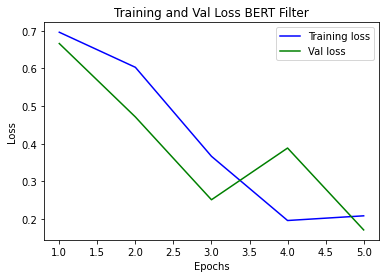

In [18]:
loss_train = losses
loss_val =losses_val
epochs = range(1,6)
plt.plot(epochs, loss_train, 'b', label='Training loss')
plt.plot(epochs, loss_val, 'g', label='Val loss')
plt.title('Training and Val Loss BERT Filter')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Filter_Loss')

plt.show()

## Evaluate on all examples, get precision and recall

In [23]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


train_loader = DataLoader(all_dataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)
pred= np.array([])
proba =np.array([])
for batch in train_loader:
    with torch.no_grad():
      net.eval()
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)
      outputs = net(input_ids, attention_mask=attention_mask)
        
      pred= np.append(pred,(torch.argmax(torch.softmax(torch.Tensor.cpu(outputs.logits).detach(),dim=1),dim=1)))
      proba = np.append(proba,torch.softmax(torch.Tensor.cpu(outputs.logits).detach(),dim=1))
print(accuracy_score(y_var,pred))
 
print(classification_report(y_var,pred))



0.4885635864592864
              precision    recall  f1-score   support

           0       0.44      0.42      0.43       499
           1       0.53      0.54      0.54       594

    accuracy                           0.49      1093
   macro avg       0.48      0.48      0.48      1093
weighted avg       0.49      0.49      0.49      1093



## Get False Positives, send to directory for further IMDB Rating Classification

In [24]:
def find_false_positives(y_var,prob):
  f_p = []
  for i,y in enumerate(y_var):
    if y == 0 and prob[i]>.7:
      f_p.append(i)
      print(all_episodes[i])
  print(len(f_p))
  return f_p


In [25]:
false_positives = find_false_positives(y_var,proba)

<Start Ep> <0> 
[The episode begins at the Krusty Krab.]
Mr. Krabs: Ooh, this is gonna be so boring.
[SpongeBob and Squidward are cleaning Mr. Krabs' office.]
SpongeBob: [whispering] You're a genius, too!
Squidward: [whispering] This is so boring!
Mr. Krabs: You're a genius!
[Mr. Krabs paints the entire Mr. Krabs Tattoo Shop.]
SpongeBob: You're a genius!
Mr. Krabs: Well, I need new customers. That's all.
Squidward: [sarcastically] Yeah. New customers.
[The scene changes to show Squidward's face. His face shows Fred.]
Squidward: [muffled] Is that done?
Fred: [muffled] Yeah. new customers?
Squidward: [muffled] What?
Fred: [muffled] Oh.
Squidward: [pulling down his shirt] I want you to have my company!
[Fred starts to leave, but makes it rung. Mr. Krabs comes in.]
Mr. Krabs: Eugene, I did it. I can finally give these little folk my all.
Fred: [closes bathroom door] Wha-what?
Mr. Krabs: I just want to make sure you all had fun.
[Mr. Krabs gives Fred three balloons.]
Fred: Wow!
Mr. Krabs: A

In [26]:
false_positives = np.array(false_positives) - (len(all_episodes)-len(fake_episodes))

In [31]:
false_positives

array([  0,   3,   5,   7,   9,  11,  13,  14,  16,  19,  21,  22,  24,
        26,  28,  30,  32,  34,  36,  38,  41,  42,  45,  46,  48,  51,
        53,  55,  56,  58,  61,  62,  65,  67,  68,  70,  72,  75,  77,
        79,  81,  82,  84,  86,  89,  90,  92,  95,  96,  99, 100, 103,
       104, 106, 108, 110, 113, 114, 116, 118, 121, 122, 124, 126, 129,
       130, 132, 135, 137, 138, 140, 143, 144, 146, 149, 151, 152, 155,
       157, 159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 178, 181,
       182, 185, 187, 189, 191, 192, 194, 197, 199, 201, 202, 205, 206,
       209, 211, 212, 215, 217, 219, 221, 223, 224, 227, 229, 231, 233,
       235, 237, 238, 241, 243, 245, 246, 249, 251, 252, 255, 256, 258,
       261, 262, 265, 266, 269, 271, 272, 275, 277, 279, 280, 283, 285,
       287, 288, 290, 292, 294, 297, 298, 300, 303, 304, 306, 309, 310,
       313, 314, 317, 319, 320, 322, 324, 326, 328, 331, 332, 335, 337,
       339, 340, 342, 344, 346, 349, 350, 353, 354, 356, 359, 36

In [30]:

false_positive_episodes=[]

for i in false_positives:

  txt = fake_episodes[i]
  print(txt)
  file = open('/content/drive/MyDrive/w266 Final Project Resources/spongebob_bert_text_updated/false_positives/spongebob_'+str(i)+'.txt','w')
  file.write(txt)
  file.close()
  false_positive_episodes.append(txt)
single_file_fp =''.join(false_positive_episodes)

Streaming output truncated to the last 5000 lines.
[SpongeBob breathes in and out of her.]
SpongeBob: [tries to deliver the chum, but she pulls him back] Oh, I'm not coming! [sobs and tries to hold onto the chum, but she pulls it back.] No, no, no! Don't let go! Negatory, kind, loving cherub. [SpongeBob holds onto the chum, but is soon forgotten.] Uh, whoa! [SpongeBob resumes choking.] I can't do this! I can't do this! I'm not good enough! [SpongeBob starts choking as he tries to pick up a flower pot. The copier lands on the trash robot and gets pushed into a trash can. He tries again, but gets picked up and thrown into one of the trash cans. He then gets smashed by a copier and thrown into a flower pot.] I'm so hungry! I don't have enough chum! I must get chum with pleasure! [He starts eating the chum, which makes him feel pain in his stomachs. He then eats some more chum and his stomach growls at him] I can't get some chum with pleasure this taste! I must get some chalice with pleasu

In [39]:
single_file_fp ='\n'.join(false_positive_episodes)

In [35]:
with open('/content/drive/MyDrive/GPT2 SIMPLE FILTERED/spongebob_updated_with_FP.txt','a') as file:
  file.write(single_file_fp)